In [13]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import shutil

data_dir = 'C://Users//johnl//Documents//GitHub//avoChecker//Quality'

In [14]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

Keras will automatically grab all the images from the directory and label them as per the folders

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size= 10, shuffle= 12453432 )

Found 124 files belonging to 6 classes.


This just lets us see some of the images with their assigned labels

In [16]:
data_iterator = data.as_numpy_iterator()

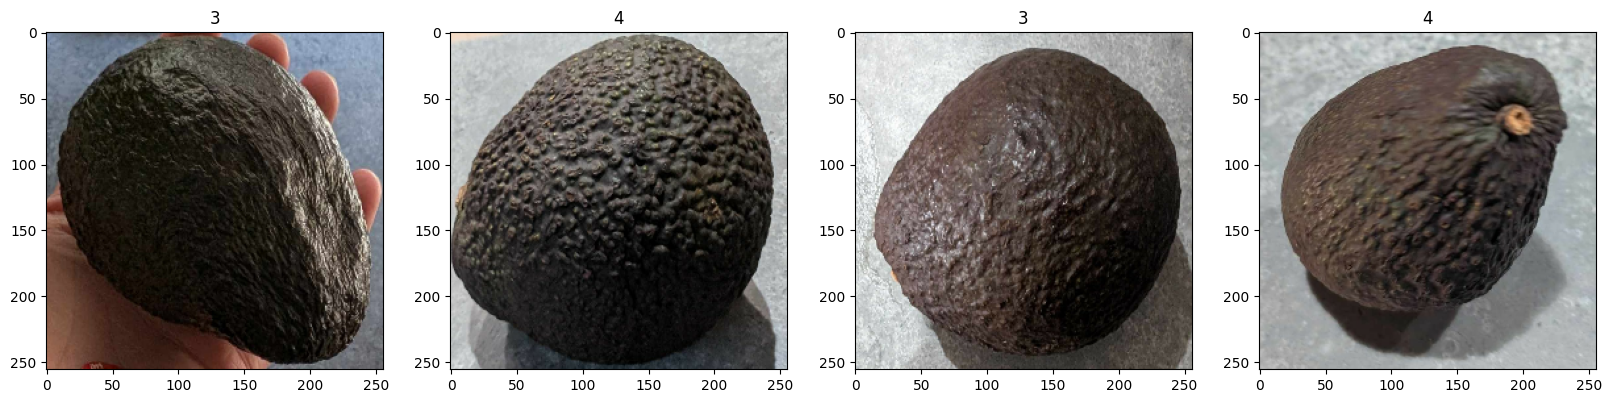

In [17]:
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

The data for the images is currently 0 - 255 (since the images are 256 x 256). We are scaling down the data to be 0-1 so that the processing is much faster

In [18]:
data = data.map(lambda x,y: (x/255, y))

In [19]:
batch = data.as_numpy_iterator().next()

This is just to visualise the images again after they have been resized but don't really need it

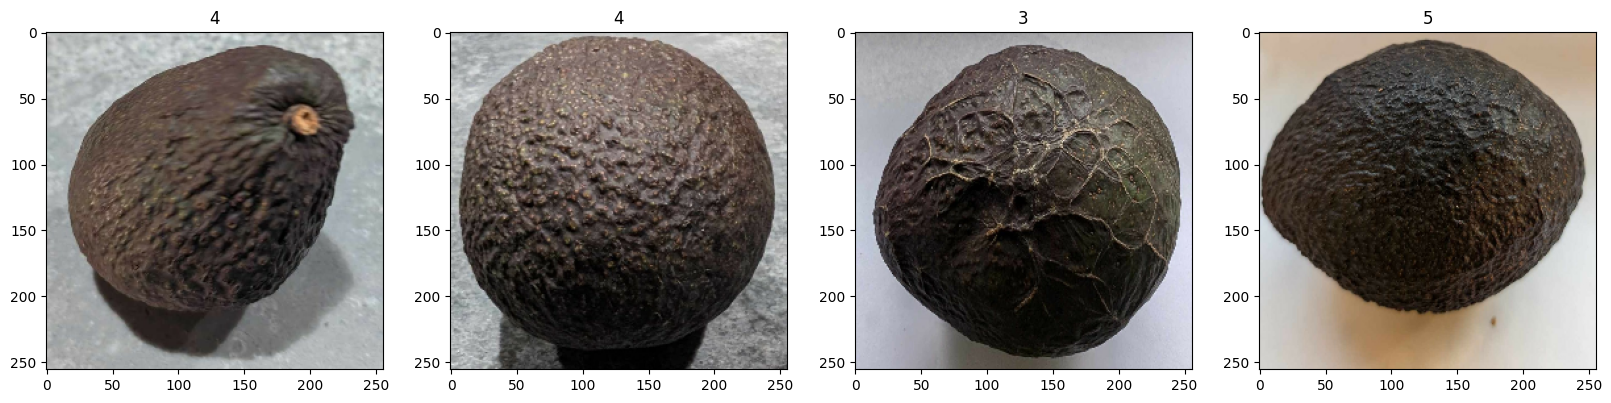

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Next we create the training/testing/validation sets. This first block just allocates the number of batches we use for each set. It is important to note that if you have not yet shuffled your data, you have to do that before you generate the sets.

In [21]:
train_size = int(len(data)*.7) -1
val_size = int(len(data)*.2)
test_size = int(len(data)*.1) +1

In [22]:
test_size

2

Next we're allocating batches to the training/testing/validation sets

In [23]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### Building the model

Import the layers and model type from keras, define the model and then add the layers

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import SGD

In [25]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
#model.add(Dense(1024, activation='relu', kernel_constraint=MaxNorm(3)))
#model.add(Dense(512, activation='relu', kernel_constraint=MaxNorm(3)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))

c:\Users\johnl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
epochs = 100
lrate = 0.002
decay = lrate/epochs
sgd = SGD(learning_rate=lrate, momentum=0.9, decay=decay, nesterov=False)

#model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.compile(loss='mse', optimizer='adam', metrics=['mae'])



c:\Users\johnl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 418,081 (1.59 MB)

 Trainable params: 418,081 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [28]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
hist = model.fit(train,  epochs=100, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 379ms/step - loss: 10.6554 - mae: 2.9186 - val_loss: 13.8750 - val_mae: 3.4583
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step - loss: 7.6192 - mae: 2.3297 - val_loss: 2.6406 - val_mae: 1.3648
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 384ms/step - loss: 3.0092 - mae: 1.4504 - val_loss: 2.2112 - val_mae: 1.1898
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 382ms/step - loss: 2.6422 - mae: 1.3766 - val_loss: 1.6060 - val_mae: 1.0157
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 395ms/step - loss: 2.1079 - mae: 1.1173 - val_loss: 1.1379 - val_mae: 0.7856
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step - loss: 1.8473 - mae: 1.0742 - val_loss: 2.2677 - val_mae: 1.2488
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 434ms/step - loss: 2.1312 - mae: 1.2407 - val_loss: 1.1335 - val_mae: 0.8935
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 391ms/step - loss: 2.0391 - mae: 1.1747 - val_loss: 1.1100 - val_mae: 0.8197
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 390m

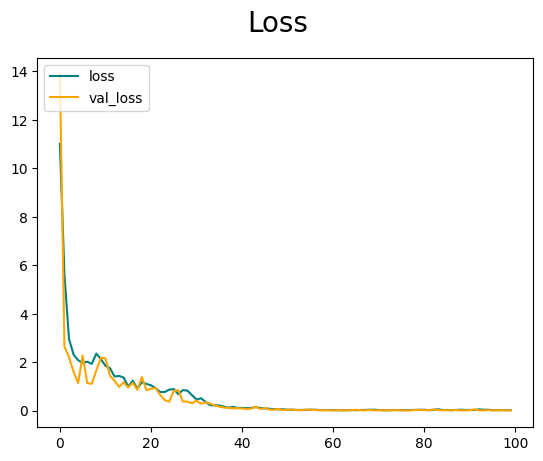

In [30]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

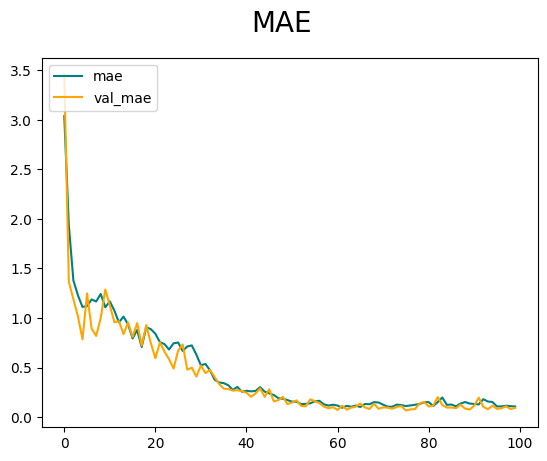

In [31]:
fig = plt.figure()
plt.plot(hist.history['mae'], color='teal', label='mae')
plt.plot(hist.history['val_mae'], color='orange', label='val_mae')
fig.suptitle('MAE', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Evaluate

By testing on the test set

In [32]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [33]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

actual_labels = []
predicted_values = []  # Changed to predicted_values to store unrounded preds

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X).flatten()  # Get the float prediction, and flatten to 1d array.

    # Store actual labels and unrounded predictions
    actual_labels.extend(y)
    predicted_values.extend(yhat)  # Store unrounded yhat

# Print the results
for actual, predicted in zip(actual_labels, predicted_values):
    print(f"Actual: {actual}, Predicted: {predicted}")

results_df = pd.DataFrame({'Actual': actual_labels, 'Predicted': predicted_values})
print(results_df)
print(results_df.head(20))

# Convert lists to NumPy arrays for scikit-learn metrics
y_true = np.array(actual_labels)
y_pred = np.array(predicted_values) #Use unrounded predictions

# Retrieve metrics (using regression metrics)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2 Score: {r2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Actual: 5, Predicted: 4.8821563720703125
Actual: 3, Predicted: 3.080639123916626
Actual: 5, Predicted: 5.104310035705566
Actual: 4, Predicted: 4.081295013427734
Actual: 3, Predicted: 3.0940966606140137
Actual: 3, Predicted: 3.1676626205444336
Actual: 5, Predicted: 4.909029960632324
Actual: 5, Predicted: 5.060070991516113
Actual: 4, Predicted: 3.965099334716797
Actual: 4, Predicted: 3.948734998703003
Actual: 1, Predicted: 0.8932912349700928
Actual: 3, Predicted: 3.0043222904205322
Actual: 4, Predicted: 3.8526151180267334
Actual: 4, Predicted: 3.970665693283081
Actual: 4, Predicted: 4.006338596343994
Actual: 1, Predicted: 1.1085931062698364
    Actual  Predicted
0        5   4.882156
1        3   3.080639
2        5   5.104310
3        4   4.081295
4        3   3.094097
5        3   3.167663
6        5   4.909030
7        5   5.060071
8        4   3.965099
9        4   3.948735
10       1   0.893291
11       3 

Up next: Think I need to convert the labels to ints, and then find out what the best loss function is for ints

In [35]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X).flatten()
    print("Raw Predictions:", yhat)  # Print the raw predictions
    yhat_classes = np.round(yhat).astype(int)
    # ... rest of the code ...

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Raw Predictions: [3.9650993  3.1914728  0.89329123 3.9975498  2.1387534  2.9681756
 3.948735   2.9289956 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Raw Predictions: [3.1081665 4.1340847 0.        2.9049442 3.2383215 2.0455616 5.0522423
 3.852615 ]


Testing on unseen images. Cropped and uncropped versions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.95383].


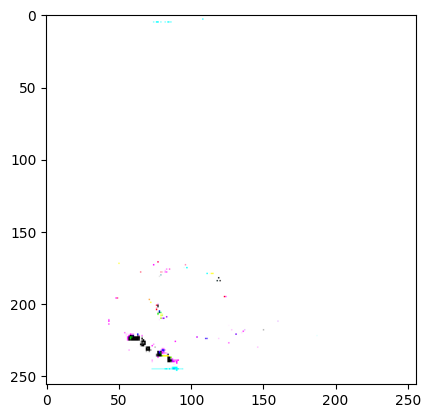

In [39]:
img = cv2.imread('Quality\\1\\490998267_1782034399031606_5012052412022513373_n.jpg')
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy())
plt.show()

In [40]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


array([[1.7964371]], dtype=float32)

Saving the model

In [42]:
from tensorflow.keras.models import load_model
model.save('avo_model.keras')
